# Parameter Tuning in Gradient Boosting (GBM) in Python 




In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


## Load dataset and split into test and train set
I use the spam dataset from HP labs via GitHub. The example will focus on tuning the parameters. Feature creating has proven to be highly effective in improving the performance of models. For simplicity, here I use only the given features and simple interactions. The dataset contains the following features:

### Importing dataset and summary statistics

In [2]:
ds=pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
ds['spam'] = ds['yesno'].map({'y': 1, 'n': 0})
ds = ds.drop(['Unnamed: 0','yesno',], axis=1)

ds.head()



,crl.tot,dollar,bang,money,n000,make,spam
0,278,0.000,0.778,0.00,0.00,0.00,1
1,1028,0.180,0.372,0.43,0.43,0.21,1
2,2259,0.184,0.276,0.06,1.16,0.06,1
3,191,0.000,0.137,0.00,0.00,0.00,1
4,191,0.000,0.135,0.00,0.00,0.00,1


In [3]:
ds.mean()


crl.tot    283.289285
dollar       0.075811
bang         0.269071
money        0.094269
n000         0.101645
make         0.104553
spam         0.394045
dtype: float64

The descriptive statistics below give a first idea on which features are correlated with spam emails. Everything related to money (dollar, money, n000) is strongly correlated with spam. Spammers use more words in capitals and the word "make" as well as exclamation points more frequently.

In [4]:
ds.groupby(['spam']).mean()


,crl.tot,dollar,bang,money,n000,make
spam,,,,,,
0,161.470947,0.011648,0.109984,0.017138,0.007088,0.073479
1,470.619415,0.174478,0.513713,0.212879,0.247055,0.152339


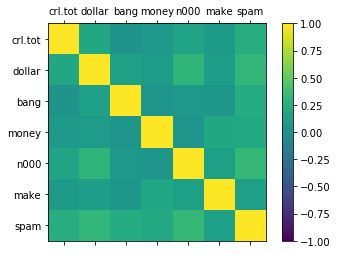

,crl.tot,dollar,bang,money,n000,make,spam
crl.tot,1.000000,0.201948,0.036321,0.080993,0.165977,0.089165,0.249164
dollar,0.201948,1.000000,0.142913,0.104691,0.310971,0.117419,0.323629
bang,0.036321,0.142913,1.000000,0.051076,0.070103,0.058292,0.241888
money,0.080993,0.104691,0.051076,1.000000,0.052587,0.188155,0.216111
n000,0.165977,0.310971,0.070103,0.052587,1.000000,0.134072,0.334787
make,0.089165,0.117419,0.058292,0.188155,0.134072,1.000000,0.126208
spam,0.249164,0.323629,0.241888,0.216111,0.334787,0.126208,1.000000


In [5]:
correlations = ds.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(ds)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

### Set Y and X space, generate interaction terms, split dataset in train and test
We expand the feature space by creating interaction terms. (Patsy is a great scikit-learn tool to create many interaction terms with one line of code) 

In [6]:
y =ds.spam
df= ds.loc[:, ds.columns != 'spam']



In [7]:
#add features by generating interaction terms
dollar_bang=df['dollar']*df['bang']
dollar_money=df['dollar']*df['money']
dollar_n000=df['dollar']*df['n000']
dollar_make=df['dollar']*df['make']
dollar_crl=df['dollar']*df['crl.tot']

bang_money=df['bang']*df['money']
bang_n000=df['bang']*df['n000']
bang_make=df['bang']*df['make']
bang_crl=df['bang']*df['crl.tot']

money_n000=df['money']*df['n000']
money_make=df['money']*df['make']
money_crl=df['money']*df['crl.tot']

n000_make=df['n000']*df['make']
n000_crl=df['n000']*df['crl.tot']

make_crl=df['make']*df['crl.tot']

In [8]:
df=df.assign(dollar_bank=dollar_bang,dollar_money=dollar_money,dollar_n000=dollar_n000,dollar_make=dollar_make,dollar_crl=dollar_crl,bang_money=bang_money, bang_n000=bang_n000,bang_make=bang_make,bang_crl=bang_crl,money_n000=money_n000,money_make=money_make,money_crl=money_crl,n000_make=n000_make,n000_crl=n000_crl,make_crl=make_crl)
             

In [9]:
df.head()

,crl.tot,dollar,bang,money,n000,make,dollar_bank,dollar_money,dollar_n000,dollar_make,...,bang_money,bang_n000,bang_make,bang_crl,money_n000,money_make,money_crl,n000_make,n000_crl,make_crl
0,278,0.000,0.778,0.00,0.00,0.00,0.000000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,216.284,0.0000,0.0000,0.00,0.0000,0.00,0.00
1,1028,0.180,0.372,0.43,0.43,0.21,0.066960,0.07740,0.07740,0.03780,...,0.15996,0.15996,0.07812,382.416,0.1849,0.0903,442.04,0.0903,442.04,215.88
2,2259,0.184,0.276,0.06,1.16,0.06,0.050784,0.01104,0.21344,0.01104,...,0.01656,0.32016,0.01656,623.484,0.0696,0.0036,135.54,0.0696,2620.44,135.54
3,191,0.000,0.137,0.00,0.00,0.00,0.000000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,26.167,0.0000,0.0000,0.00,0.0000,0.00,0.00
4,191,0.000,0.135,0.00,0.00,0.00,0.000000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,25.785,0.0000,0.0000,0.00,0.0000,0.00,0.00


Split dataset into train and test set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

### Run a baseline model without tuning
I use the following baseline scikit-learn library settings.<br>


Accuracy of the GBM on test set: 0.877
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       563
           1       0.88      0.79      0.83       358

    accuracy                           0.88       921
   macro avg       0.88      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



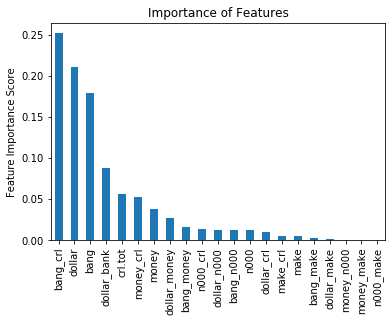

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

The plot displays the importance of the feature: The number of words in capital and bang seem to have the highest predictive power.

With this first model, we obtain a rate of 0.90 of true positives (positive meaning spam) and 0.87 true negatives and an accuracy of 0.88. 

